In [3]:
import pandas as pd
import helper.entsoe_wrapper as entsoe_wrapper
import helper.intensity as its
import helper.capacity as cap
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np
country='FR'
start=pd.Timestamp('2022-01-01', tz='UTC')
end=pd.Timestamp('2023-01-01', tz='UTC')

In [6]:
server_countries=["DE","AT","FR","BE","NL","SE","ES","IT","IE","PL"]

In [33]:
intensity_flows=[]
intensities=[]
for country in server_countries:
    print("Country: "+country)
    # Get data
    intensity_flow=its.get_average_intensity_flow(country, start, end,water=True)
    intensity=its.get_average_intensity(country, start, end,water=True)
    intensity_flows.append(intensity_flow.mean())
    intensities.append(intensity.mean())

Country: DE
Country: AT
Country: FR
Country: BE
Country: NL
Country: SE
Country: ES
Country: IT
Country: IE
Country: PL


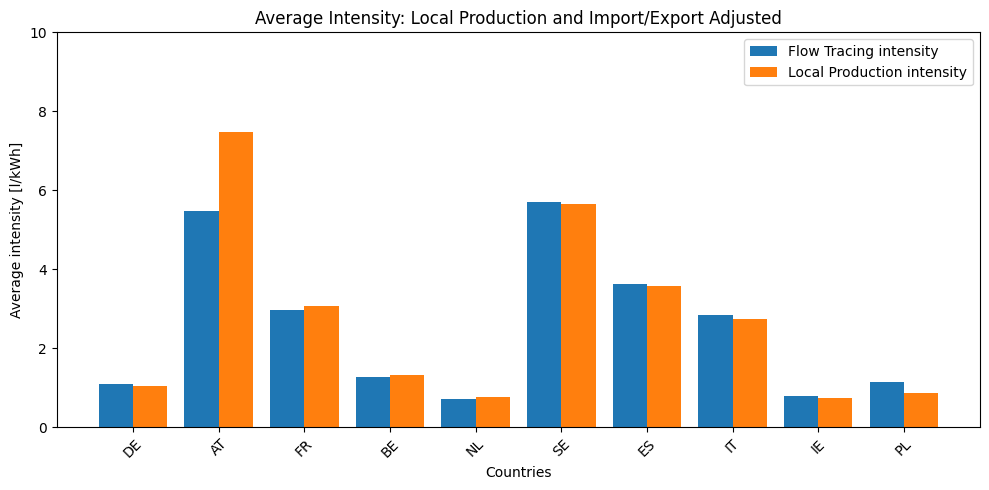

In [42]:
# Creating the plot
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.8

# Stacking bars for production and import intensity
bar_width = 0.4
p1 = ax.bar(np.arange(len(server_countries)), intensity_flows, width=bar_width, label="Flow Tracing intensity")
p2 = ax.bar(np.arange(len(server_countries)) + bar_width, intensities, width=bar_width, label="Local Production intensity")
ax.set_xticks(np.arange(len(server_countries)) + bar_width / 2)
ax.set_xticklabels(server_countries)


# Setting labels and title
ax.set_ylabel("Average intensity [l/kWh]")
ax.set_xlabel("Countries")
ax.set_title("Average Intensity: Local Production and Import/Export Adjusted")
ax.set_ylim(0, 10)
ax.legend()

# Display adjustments
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("average_intensity_comparison.png",dpi=300)
plt.show()

In [44]:
# Fetch generation data
generation_df = entsoe_wrapper.get_generation_data_1h(country, start, end)

# Remove columns containing "Actual Consumption"
generation_df = generation_df.loc[:, ~generation_df.columns.str.contains("Actual Consumption")]

# Rename columns
generation_df.columns = generation_df.columns.str.replace('_Actual Aggregated', '')

# Create residual generation dataframe by dropping specific columns
residual_gen_df = generation_df.drop(columns=generation_df.columns.intersection([
    'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore','Biomass','Geothermal','Nuclear','Other'
]))

# Create renewable generation dataframe by dropping specific columns
renewable_gen_df = generation_df.drop(columns=generation_df.columns.intersection([
    'Biomass', 'Fossil Brown coal/Lignite', 'Fossil Gas', 'Fossil Hard coal',
    'Fossil Oil', 'Geothermal', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
    'Hydro Water Reservoir', 'Nuclear', 'Other'
]))

In [54]:
emission_op=its.get_average_flexible_intensity(country,start,end,water=False)
water_op=its.get_average_flexible_intensity(country,start,end,water=True)
emission_op=its.get_average_intensity(country,start,end,water=False)
res_share=residual_gen_df.sum(axis=1)/generation_df.sum(axis=1)*100
generation_df=generation_df.ffill()
generation_sum=generation_df.sum(axis=1)

In [55]:
residual_gen_df.interpolate(method='linear',inplace=True)

<Axes: >

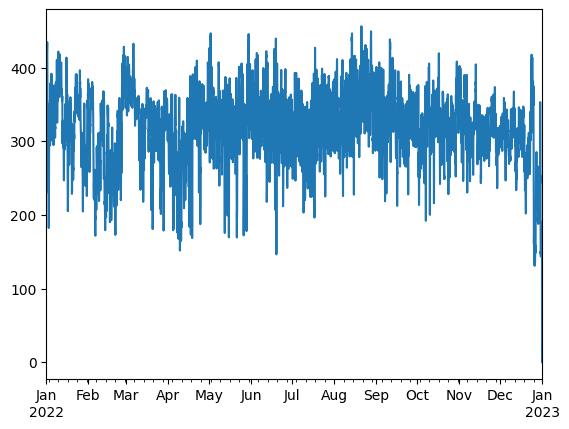

In [48]:
emission_op.plot()

In [49]:
emission_delta=(emission_op-emission_op.shift(1)).fillna(0)
generation_delta=(residual_gen_df.sum(axis=1)-residual_gen_df.sum(axis=1).shift(1)).fillna(0)
gen_delta=(generation_df.sum(axis=1)-generation_df.sum(axis=1).shift(1)).fillna(0)
water_delta=(water_op-water_op.shift(1)).fillna(0)

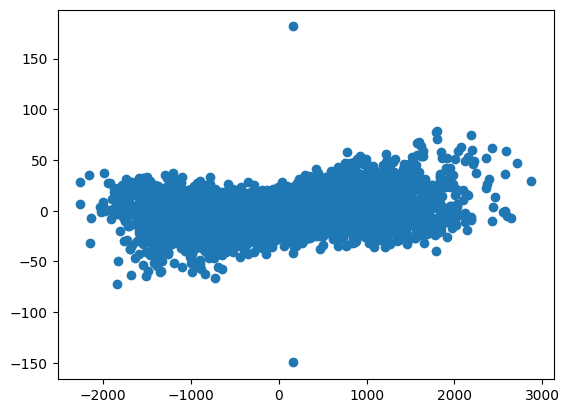

In [51]:
#scatter plot of generation vs emission
plt.scatter(generation_delta,emission_delta)

In [52]:
generation_sum=generation_sum.reset_index()
generation_sum.columns=['date','generation']
generation_sum.sort_values(by='generation', inplace=True)
generation_sum=generation_sum.reset_index(drop=True)
generation_sum["cluster"]=generation_sum.index//int(generation_sum.shape[0]/10)
generation_sum.index=generation_sum['date']
generation_sum=generation_sum.drop(columns=['date'])
generation_sum=generation_sum.sort_index()

In [53]:
# Define the number of clusters
num_clusters = 5

# Calculate the cluster for each row based on res_share
generation_sum["res_cluster"] = (res_share // (100 / num_clusters)).astype(int)

# Ensure the cluster values are within the valid range
generation_sum["res_cluster"] = generation_sum["res_cluster"].clip(0, num_clusters - 1)



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [15]:
result=np.zeros((10,5))

for i in range(10):
    for s in range(5):
        # Calculate the number of entries for each combination of clusters
        result[i][s]=generation_sum[(generation_sum["cluster"] == i) & (generation_sum["res_cluster"] == s)].shape[0]    

In [16]:
# fit a regression model and save the r2 value to a numpy array for each cluster combination with more than 50 entries and put 0 otherwise
r2=np.zeros((10,10))
for i in range(10):
    for s in range(5):
        if result[i][s]>50:
            indices = generation_sum[(generation_sum["cluster"] == i) & (generation_sum["res_cluster"] == s)].index
            X = generation_delta.loc[indices].values.reshape(-1, 1)
            y = emission_delta.loc[indices].values.reshape(-1, 1)
            reg = LinearRegression().fit(X, y)
            r2[i][s]=reg.score(X, y)

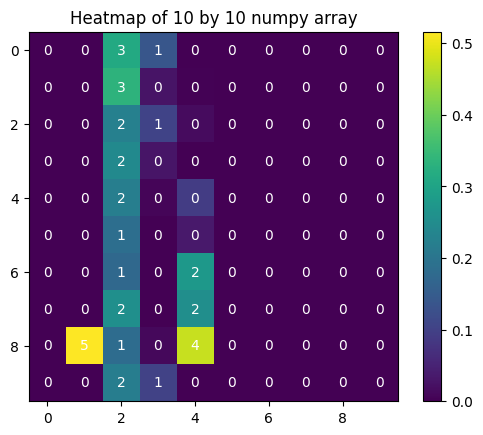

In [17]:
import matplotlib.pyplot as plt
for i in range(10):
    for j in range(10):
        plt.text(j, i, int(r2[i, j]*10), ha='center', va='center', color='white')
plt.imshow(r2, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of 10 by 10 numpy array')
plt.show()

In [56]:
X=generation_delta.values.reshape(-1,1)
y=emission_delta.values.reshape(-1,1)
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
pred = model.predict(X)
print('Bestimmungsmaß R²: ' + str(round(model.score(X,y),3)))
print('Steigung: ' + str(np.around(model.coef_.item(), decimals=3)))
print('Intercept: ' + str(model.intercept_))

Bestimmungsmaß R²: 0.039
Steigung: 0.004
Intercept: 0.0
